# Recovery of Gold in Mining


Gold mining is a very detailed process. Mined ore undergoes primary processing to get the ore mixture or rougher feed, which is the raw material for flotation (also known as the rougher process). Gold ore mixture is fed into the float banks to obtain rougher gold concentrate and rougher tails (product residues with a low concentration of valuable metals).  This process is not completely stable.  The material post flotation is sent into purification.The rougher concentrate undergoes two stages of purification. After purification, we have the final concentrate and new tails.

Demonstration of machine learning knowledge will be demonstrated by preparing, analyzing, and building a model connected to raw data of gold mining from a warehouse. The data is stored in three files:gold_recovery_train.csv(training dataset), gold_recovery_test.csv (test dataset), gold_recovery_full.csv (source dataset). The source dataset contains the training and test sets with all the features.  Some of the features that are present in the training set may be absent from the test set since measured later.

Data Preparation will involve:
1.1 Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. 
1.2. Analyze the features not available in the test set.
1.3. Perform data preprocessing.

Data Analyziation will involve:
2.1. Discovery of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
2.2. Comparision of the feed particle size distributions in the training set and in the test set. 
2.3. Evaluate the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate (abnormalities in distribution, decisions to remove or not) 

Model Builiding 
3.1. Write a function to calculate the final sMAPE value.
3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

Feature naming follows following pattern:
[stage].[parameter_type].[parameter_name]
Example: rougher.input.feed_ag

Possible values for [stage]:
rougher — flotation
primary_cleaner — primary purification
secondary_cleaner — secondary purification
final — final characteristics

Possible values for [parameter_type]:
input — raw material parameters
output — product parameters
state — parameters characterizing the current state of the stage
calculation — calculation characteristics

Recovery calculated by:{[C*(F-T)]/[F* (C-T)]}*100
where:
C — share of gold in the concentrate right after flotation 
F — share of gold in the feed before flotation 
T — share of gold in the rougher tails right after flotation 

Evaluation will be performed using sMAPE(symmetric Mean Absolute Percentage Error) since it takes into takes into account the scale of both the target and the prediction. 

We need to predict two values:
rougher concentrate recovery rougher.output.recovery
final concentrate recovery final.output.recovery





In [1]:
#import all needed libraries 
import pandas as pd
import numpy as np

#import display libraries 
import seaborn as sns
import matplotlib.pyplot as plt

#import named regression models 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



#import ability to split into training and testing data sets 
from sklearn.model_selection import train_test_split

#import ability to evaluate accuracy of data 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


from joblib import dump

#needed to compare. 
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


In [2]:
gtrain=pd.read_csv('/datasets/gold_recovery_train.csv')
gtest=pd.read_csv('/datasets/gold_recovery_test.csv')
gfull=pd.read_csv('/datasets/gold_recovery_full.csv')

Data Preparation

In [3]:
golds=[gtrain, gtest, gfull]

In [4]:
#data cleaning
for i, gold in enumerate(golds):
    #print sample of df
    print(f'Dataframe Info for or Site {i}')
    print(gold.info())
    print(gold.isna().sum())
    print(gold.columns)
    print('******************************************')

Dataframe Info for or Site 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                          

In [5]:
gtrain.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [6]:
gtest.head(3)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [7]:
gfull.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [8]:
#check recovery calculation in gtrain
C=gtrain['rougher.output.concentrate_au']
F=gtrain['rougher.input.feed_au']
T=gtrain['rougher.output.tail_au']
#create new column with recovery calculation 
gtrain['recovery_check']=(((C*(F-T))/(F* (C-T)))*100)
#create dataframe of previously calculated and fresh to easily compare 
df_train_recovery=gtrain[['rougher.output.recovery','recovery_check' ]]
df_train_recovery.head(10)

,rougher.output.recovery,recovery_check
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
5,88.156912,88.156912
6,88.168065,88.168065
7,87.668336,87.668336
8,87.035862,87.035862
9,87.650868,87.650868


In [9]:
#calculate MEA 
mea=(df_train_recovery['rougher.output.recovery']-df_train_recovery['recovery_check']).abs().mean()
print(f'MEA of provided recovery and student verified recovery:',mea)

MEA of provided recovery and student verified recovery: 9.303415616264301e-15


The recovery calculation in the provided dataframe matches the recovery check performed.  The MEA is so miniscule (9.3e-15) which is a positive report.   

In [10]:
#find if missing columns in training dataframe 
def missing_columns (df,reference_df):
    missing_columns= [col for col in reference_df.columns if col not in df.columns]
    if missing_columns:
        print(f"Columns which are missing between dataframes:")
        for col in missing_columns:
            print(f"={col}")
    else:
        print(f"All columns match between dataframes.")
    return missing_columns

In [11]:
gtest.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

In [12]:
missing=missing_columns(gtest,gtrain)

Columns which are missing between dataframes:
=final.output.concentrate_ag
=final.output.concentrate_pb
=final.output.concentrate_sol
=final.output.concentrate_au
=final.output.recovery
=final.output.tail_ag
=final.output.tail_pb
=final.output.tail_sol
=final.output.tail_au
=primary_cleaner.output.concentrate_ag
=primary_cleaner.output.concentrate_pb
=primary_cleaner.output.concentrate_sol
=primary_cleaner.output.concentrate_au
=primary_cleaner.output.tail_ag
=primary_cleaner.output.tail_pb
=primary_cleaner.output.tail_sol
=primary_cleaner.output.tail_au
=rougher.calculation.sulfate_to_au_concentrate
=rougher.calculation.floatbank10_sulfate_to_au_feed
=rougher.calculation.floatbank11_sulfate_to_au_feed
=rougher.calculation.au_pb_ratio
=rougher.output.concentrate_ag
=rougher.output.concentrate_pb
=rougher.output.concentrate_sol
=rougher.output.concentrate_au
=rougher.output.recovery
=rougher.output.tail_ag
=rougher.output.tail_pb
=rougher.output.tail_sol
=rougher.output.tail_au
=seconda

In [13]:
#remove columns which are part of target 
missing.remove('rougher.output.recovery')
missing.remove('final.output.recovery')
missing

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleane

In [14]:
gtrain=gtrain.drop(columns=missing)
check_missing_columns=missing_columns(gtest,gtrain)

Columns which are missing between dataframes:
=final.output.recovery
=rougher.output.recovery


All missing columns have a datatype of float64. Double checked for columns to be removed.  Only mismatch remaining is the targets which were intentionally removed.  Targets must remain for machine learning at end.  

In [15]:
#write function to merge missing columns into gtest dataframe for complete information 
def add_missing_columns(df, reference_df, missing_cols):
    for col in missing_cols:
        df[col] = reference_df[col]
    return df

In [16]:
#add missing columns to test so target exists 
gtest=add_missing_columns(gtest,gtrain,check_missing_columns)
recheck=missing_columns(gtest,gtrain)

All columns match between dataframes.


In [17]:
#write function to remove columns not present in df. 
def remove_missing_columns(df, reference_df):
    # Find columns in `df` that are not in `reference_df`
    columns_to_remove = [col for col in df.columns if col not in reference_df.columns]
    # Drop the missing columns
    df = df.drop(columns=columns_to_remove, errors='ignore')
    return df

In [18]:
#gtrain issues to be resolved. 

#change date column datatype from object
gtrain['date']=pd.to_datetime(gtrain['date'], format='%Y/%m/%d %H:%M')
#check for duplicate rows
gtrain.duplicated().sum()

0

In [19]:
#in gtrain Find columns with missing values
columns_with_missing = gtrain.columns[gtrain.isnull().any()].tolist()

# Replace missing values with the mean of each column
for col in columns_with_missing:
    mean_value = gtrain[col].mean()  # Calculate mean
    gtrain[col].fillna(mean_value, inplace=True)  # Replace NaN with mean

# check all means added  
print(gtrain.isna().sum())


date                                          0
final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate       

In [20]:
#gtest issues to be resolved
#change date column datatype from object
gtest['date']=pd.to_datetime(gtest['date'], format='%Y/%m/%d %H:%M')
#check for duplicate rows
gtest.duplicated().sum()

0

In [21]:
#in gtest Find columns with missing values
columns_with_missing = gtest.columns[gtest.isna().any()].tolist()

# Replace missing values with the mean of each column
for col in columns_with_missing:
    mean_value = gtest[col].mean()  # Calculate mean
    gtest[col].fillna(mean_value, inplace=True)  # Replace NaN with mean

# check all means added  
print(gtest.isna().sum())

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

Data Analyzation 

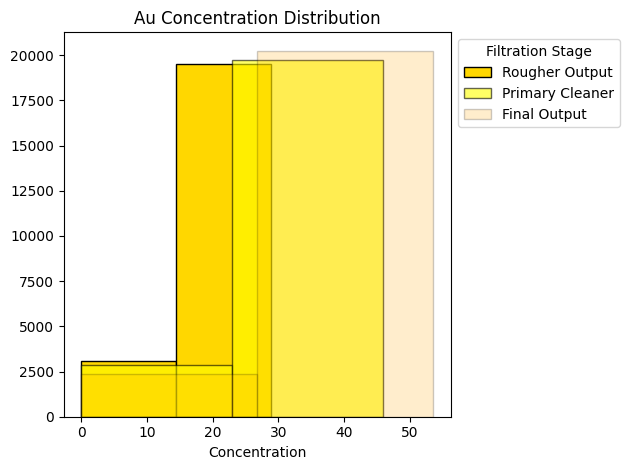

In [22]:
# Specify the columns you want to keep
au_columns = ['rougher.input.feed_au', 'final.output.concentrate_au', 'final.output.tail_au', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_au']

# Create a new DataFrame with the selected columns
au = gfull[au_columns]
au_mean=au


#plt.hist(au_mean,bins=10, color='gold', edgecolor='black')
plt.hist(au_mean['rougher.output.concentrate_au'], bins=2, color='gold', edgecolor='black', alpha=1, label='Rougher Output')
plt.hist(au_mean['primary_cleaner.output.concentrate_au'], bins=2, color='yellow', edgecolor='black', alpha=0.6, label='Primary Cleaner')
plt.hist(au_mean['final.output.concentrate_au'], bins=2, color='orange', edgecolor='black', alpha=0.2, label='Final Output')
              
# Add labels and title
plt.title('Au Concentration Distribution')
plt.xlabel('Concentration')

# Show the plot
plt.legend(title='Filtration Stage', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to fit the legend
plt.tight_layout()
plt.show()


The highest purification stage of gold is the final output.  This makes sense as the desired outcome of purification is high gold values.  The lowest gold volume is present in the product residue from the first rough purification stage (rougher.output.tail_au).  

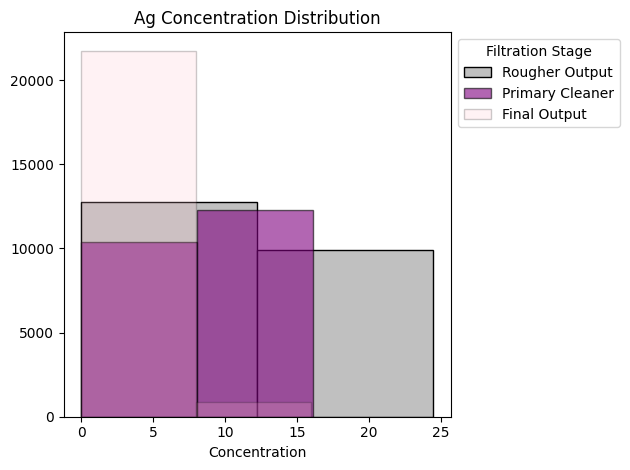

In [23]:
ag_list = [col for col in gfull.columns if 'ag' in col]

# Specify the columns you want to keep
ag_columns = ['rougher.input.feed_ag', 'final.output.concentrate_ag', 'final.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.tail_ag', 'rougher.output.concentrate_ag', 'rougher.output.tail_ag', 'secondary_cleaner.output.tail_ag']

# Create a new DataFrame with the selected columns
ag = gfull[ag_columns]
ag_mean=ag


#plt.hist(au_mean,bins=10, color='gold', edgecolor='black')
plt.hist(ag_mean['rougher.output.concentrate_ag'], bins=2, color='silver', edgecolor='black', alpha=1, label='Rougher Output')
plt.hist(ag_mean['primary_cleaner.output.concentrate_ag'], bins=2, color='purple', edgecolor='black', alpha=0.6, label='Primary Cleaner')
plt.hist(ag_mean['final.output.concentrate_ag'], bins=2, color='pink', edgecolor='black', alpha=0.2, label='Final Output')
              
# Add labels and title
plt.title('Ag Concentration Distribution')
plt.xlabel('Concentration')

# Show the plot
plt.legend(title='Filtration Stage', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to fit the legend
plt.tight_layout()
plt.show()


Silver's highest concentration during the purification process is the product output from the second cleaning (primary_cleaner.output.tail_ag).  Closely following is the product output from the third cleaning process (secondary_cleaner.output.tail_ag).  As the gold refining process occurs there will be less volumes of any other metals present.  The max volume present of gold is 13 while the max gold present is closer to 40.  

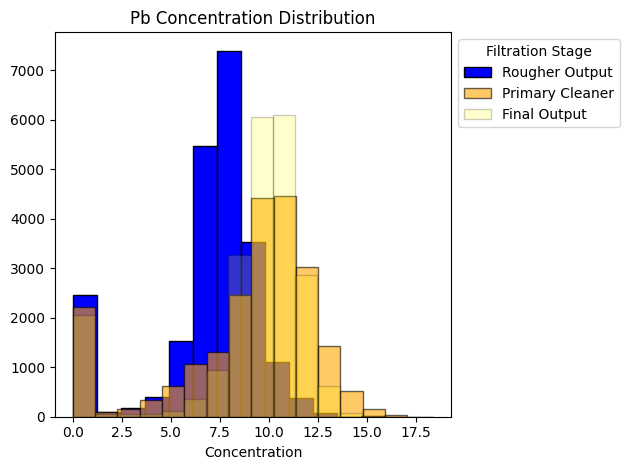

In [24]:
pb_list = [col for col in gfull.columns if 'pb' in col]

# Specify the columns you want to keep
pb_columns = ['rougher.input.feed_pb', 'final.output.concentrate_pb', 'final.output.tail_pb', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.tail_pb', 'rougher.output.concentrate_pb', 'rougher.output.tail_pb', 'secondary_cleaner.output.tail_pb']

# Create a new DataFrame with the selected columns
pb = gfull[pb_columns]
pb_mean=pb


#plt.hist(au_mean,bins=10, color='gold', edgecolor='black')
plt.hist(pb_mean['rougher.output.concentrate_pb'], bins=15, color='blue', edgecolor='black', alpha=1, label='Rougher Output')
plt.hist(pb_mean['primary_cleaner.output.concentrate_pb'], bins=15, color='orange', edgecolor='black', alpha=0.6, label='Primary Cleaner')
plt.hist(pb_mean['final.output.concentrate_pb'], bins=15, color='yellow', edgecolor='black', alpha=0.2, label='Final Output')
              
# Add labels and title
plt.title('Pb Concentration Distribution')
plt.xlabel('Concentration')

# Show the plot
plt.legend(title='Filtration Stage', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to fit the legend
plt.tight_layout()
plt.show()

Lead's highest concentration point is in the finished stage of gold purification (final.output.concentrate_pb).  The values of lead present (9.11) are much lower than volume of gold present in final stages (about 40).  

In [25]:
#Compare the feed particle size distributions in the training set and in the test set.
train_size = [col for col in gtrain.columns if 'feed_size' in col]
test_size = [col for col in gtest.columns if 'feed_size' in col]
print(train_size)
print(test_size)

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']
['primary_cleaner.input.feed_size', 'rougher.input.feed_size']


In [26]:
# Specify the columns you want to keep
train_size_columns = ['primary_cleaner.input.feed_size', 'rougher.input.feed_size']
test_size_columns = ['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

# Create a new DataFrame with the selected columns
train_sc=gtrain[train_size_columns]
test_sc=gtest[test_size_columns]

#rename the columns to identify source
tr_sc=train_sc.rename(columns={'primary_cleaner.input.feed_size':'Train_Primary_Cleaner', 'rougher.input.feed_size':'Train_Rough'})
te_sc=test_sc.rename(columns={'primary_cleaner.input.feed_size':'Test_Primary_Cleaner', 'rougher.input.feed_size':'Test_Rough'})

In [27]:
# Concatenate the DataFrames
feed_size = pd.concat([tr_sc, te_sc], ignore_index=True)

# Check the result
fs=feed_size
fs.head(5)

,Train_Primary_Cleaner,Train_Rough,Test_Primary_Cleaner,Test_Rough
0,7.25,55.486599,NaN,NaN
1,7.25,57.278666,NaN,NaN
2,7.25,57.510649,NaN,NaN
3,7.25,57.792734,NaN,NaN
4,7.25,56.047189,NaN,NaN


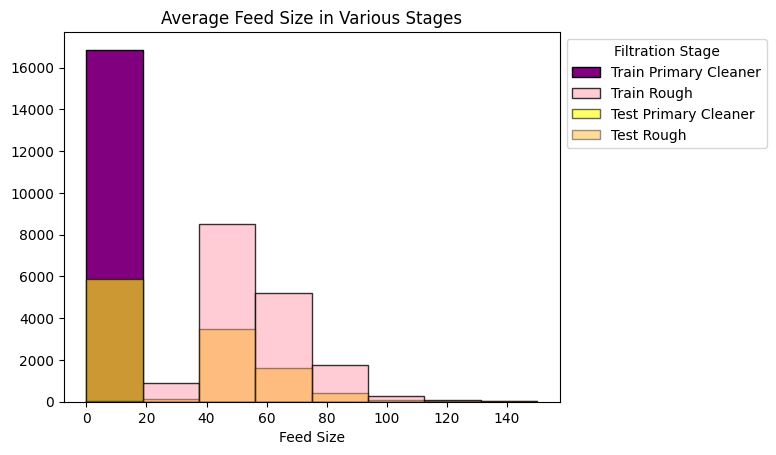

In [28]:
#visualize

#plt.hist(au_mean,bins=10, color='gold', edgecolor='black')
plt.hist(fs['Train_Primary_Cleaner'], bins=8, color='purple', edgecolor='black', alpha=1, range=[0,150], label='Train Primary Cleaner')
plt.hist(fs['Train_Rough'], bins=8, color='pink', edgecolor='black', alpha=0.8,  range=[0,150], label='Train Rough')
plt.hist(fs['Test_Primary_Cleaner'], bins=8, color='yellow', edgecolor='black', range=[0,150], alpha=0.6, label='Test Primary Cleaner')
plt.hist(fs['Test_Rough'], bins=8, color='orange', edgecolor='black', alpha=0.4, range=[0,150], label='Test Rough')

              
# Add labels and title
plt.title('Average Feed Size in Various Stages')
plt.xlabel('Feed Size')

# Show the plot
plt.legend(title='Filtration Stage', loc='upper left', bbox_to_anchor=(1, 1))


The average feed size is exactly the same according to the phase of gold purification between the two dataframes.  In boh the training and testing dataset the average feed size during primary cleaner is 7.264651.  During purification stage rough the average feed size is 55.937535.  This is an indication that the machine learning model will be well trained since similiar data is present in both dataframes. 

In [29]:
print('Shape of the dataset before handling abnormal values:', gfull.shape)
gfull['rougher.input.total_concentration']=gfull['rougher.input.feed_au']+gfull['rougher.input.feed_ag']+gfull['rougher.input.feed_pb']
gfull['rougher.output.total_concentration']=gfull['rougher.output.concentrate_au']+gfull['rougher.output.concentrate_ag']+gfull['rougher.output.concentrate_pb']
gfull['final.output.total_concentration']=gfull['final.output.concentrate_au']+gfull['final.output.concentrate_ag']+gfull['final.output.concentrate_pb']

#check for abnormal values (anything where the sum of at each stage is less than or equal to 0) 
abnormal_rows=gfull[(gfull['rougher.input.total_concentration'] <= 0) | (gfull['rougher.output.total_concentration'] <= 0) | (gfull['final.output.total_concentration'] <= 0)]

#remove abnormal rows 
gfull=gfull.drop(abnormal_rows.index)

#check shape of dataset
print('Shape of the full dataset after handling abnormal values:', gfull.shape)


Shape of the dataset before handling abnormal values: (22716, 87)
Shape of the full dataset after handling abnormal values: (20472, 90)


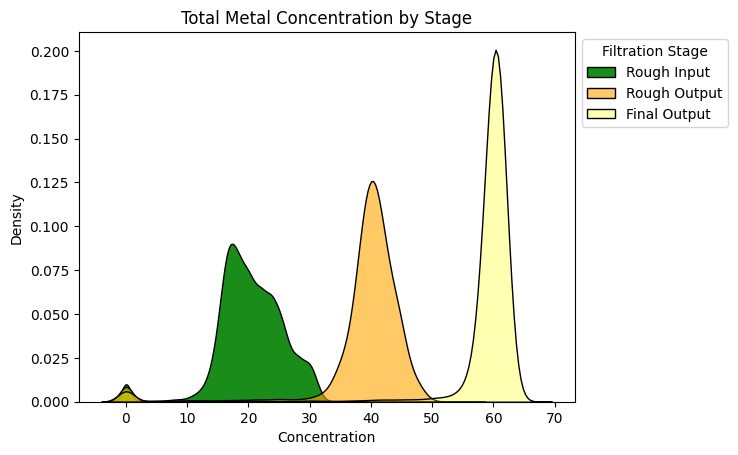

In [30]:

sns.kdeplot(gfull['rougher.input.total_concentration'], color='green', edgecolor='black', alpha=0.9, label='Rough Input',fill=True)
sns.kdeplot(gfull['rougher.output.total_concentration'], color='orange', edgecolor='black', alpha=0.6, label='Rough Output', fill=True)
sns.kdeplot(gfull['final.output.total_concentration'], color='yellow', edgecolor='black', alpha=0.3, label='Final Output', fill=True)
# Add labels and title
plt.title('Total Metal Concentration by Stage')
plt.xlabel('Concentration')
# Show the plot
plt.legend(title='Filtration Stage', loc='upper left', bbox_to_anchor=(1, 1))



In [31]:
#pull together metal concentrations 
metal_concentrations=gfull[['final.output.concentrate_ag','final.output.concentrate_au','final.output.concentrate_pb']]
#add a column of summation 
metal_concentrations['sum']=gfull['final.output.concentrate_ag'] + gfull['final.output.concentrate_au'] + gfull['final.output.concentrate_pb']



/tmp/ipykernel_50/2478234673.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_concentrations['sum']=gfull['final.output.concentrate_ag'] + gfull['final.output.concentrate_au'] + gfull['final.output.concentrate_pb']


In [32]:
#function for concentration of each metal at stages 
def metal_sum(df,stage, metal):
#     metal_id=['_au','_ag','_pb']
    total_metal=df[stage+metal]
    print(total_metal.shape)
    print(total_metal.head())
    return total_metal

(20472,)
0    6.486150
1    6.478583
2    6.362222
3    6.118189
4    5.663707
Name: rougher.input.feed_au, dtype: float64
(20472,)
0    19.793808
1    20.050975
2    19.737170
3    19.320810
4    19.216101
Name: rougher.output.concentrate_au, dtype: float64
(20472,)
0    42.192020
1    42.701629
2    42.657501
3    42.689819
4    42.774141
Name: final.output.concentrate_au, dtype: float64


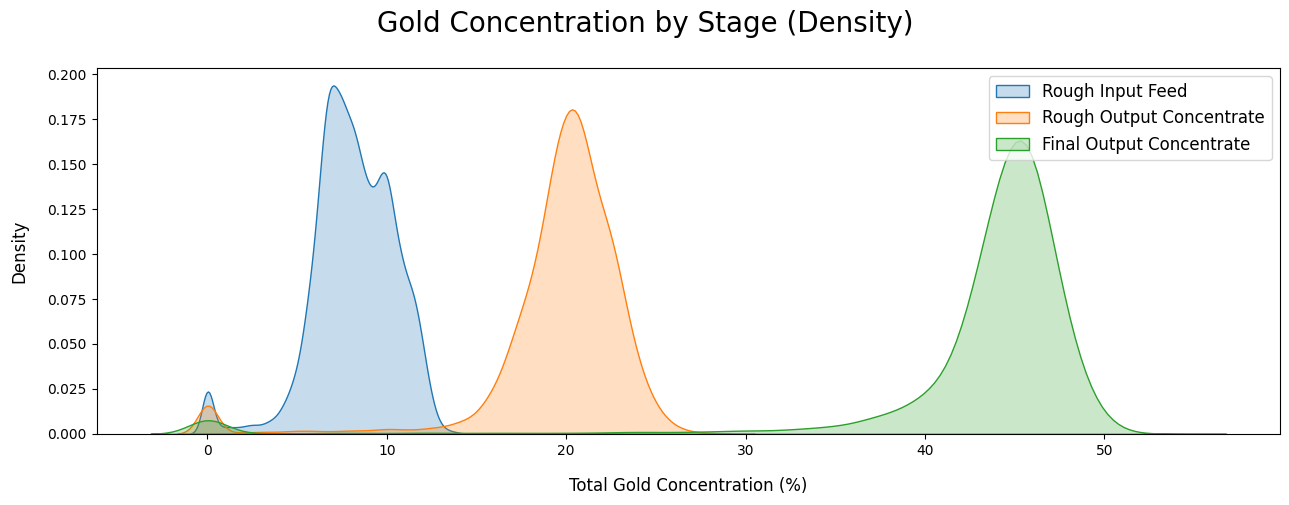

In [33]:
#visualize Gold
fig=plt.figure(figsize=(13,5))
fig.suptitle('Gold Concentration by Stage (Density)',fontsize=20,y=1)

sns.kdeplot(metal_sum (gfull,'rougher.input.feed', '_au'),label='Rough Input Feed',fill=True)
sns.kdeplot(metal_sum (gfull,'rougher.output.concentrate', '_au'),label='Rough Output Concentrate', fill=True)
sns.kdeplot(metal_sum (gfull,'final.output.concentrate', '_au'), label='Final Output Concentrate', fill=True)

plt.legend(fontsize=12)
plt.xlabel('Total Gold Concentration (%)', fontsize=12, labelpad=14)
plt.ylabel('Density', fontsize=12,labelpad=14)
# Add labels and title
plt.tight_layout()
plt.show()

(20472,)
0    6.100378
1    6.161113
2    6.116455
3    6.043309
4    6.060915
Name: rougher.input.feed_ag, dtype: float64
(20472,)
0    11.500771
1    11.615865
2    11.695753
3    11.915047
4    12.411054
Name: rougher.output.concentrate_ag, dtype: float64
(20472,)
0    6.055403
1    6.029369
2    6.055926
3    6.047977
4    6.148599
Name: final.output.concentrate_ag, dtype: float64


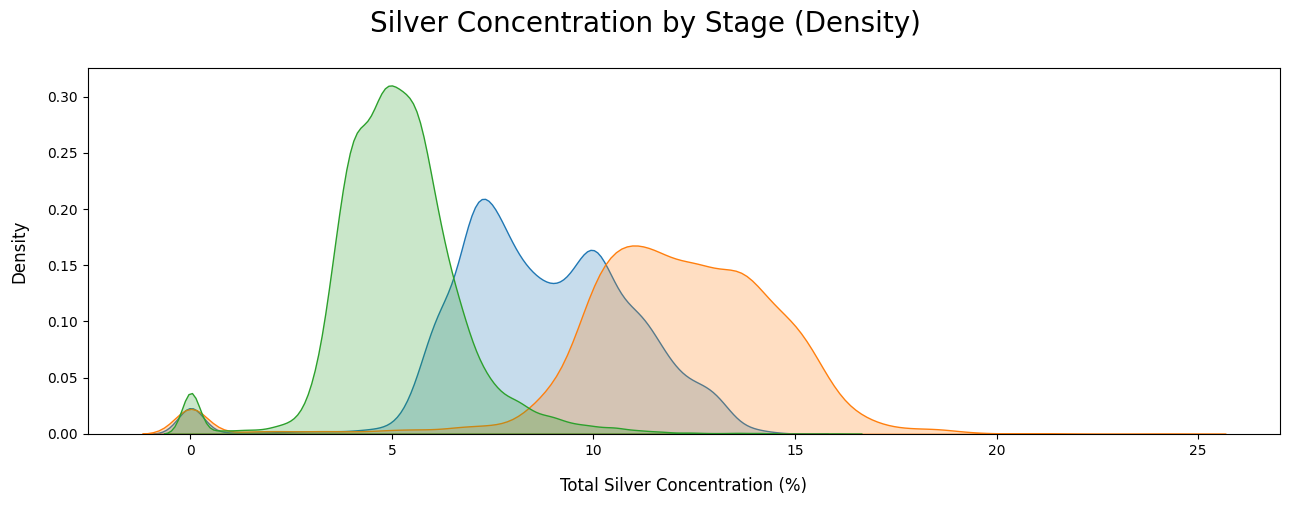

In [34]:
#visualize Silver 
fig=plt.figure(figsize=(13,5))
fig.suptitle('Silver Concentration by Stage (Density)',fontsize=20,y=1)

sns.kdeplot(metal_sum (gfull,'rougher.input.feed', '_ag'),label='Rough Input Feed',fill=True)
sns.kdeplot(metal_sum (gfull,'rougher.output.concentrate', '_ag'),label='Rough Output Concentrate', fill=True)
sns.kdeplot(metal_sum (gfull,'final.output.concentrate', '_ag'), label='Final Output Concentrate', fill=True)

plt.xlabel('Total Silver Concentration (%)', fontsize=12, labelpad=14)
plt.ylabel('Density', fontsize=12,labelpad=14)
# Add labels and title
plt.tight_layout()
plt.show()

(20472,)
0    2.284912
1    2.266033
2    2.159622
3    2.037807
4    1.786875
Name: rougher.input.feed_pb, dtype: float64
(20472,)
0    7.101074
1    7.278807
2    7.216833
3    7.175616
4    7.240205
Name: rougher.output.concentrate_pb, dtype: float64
(20472,)
0     9.889648
1     9.968944
2    10.213995
3     9.977019
4    10.142511
Name: final.output.concentrate_pb, dtype: float64


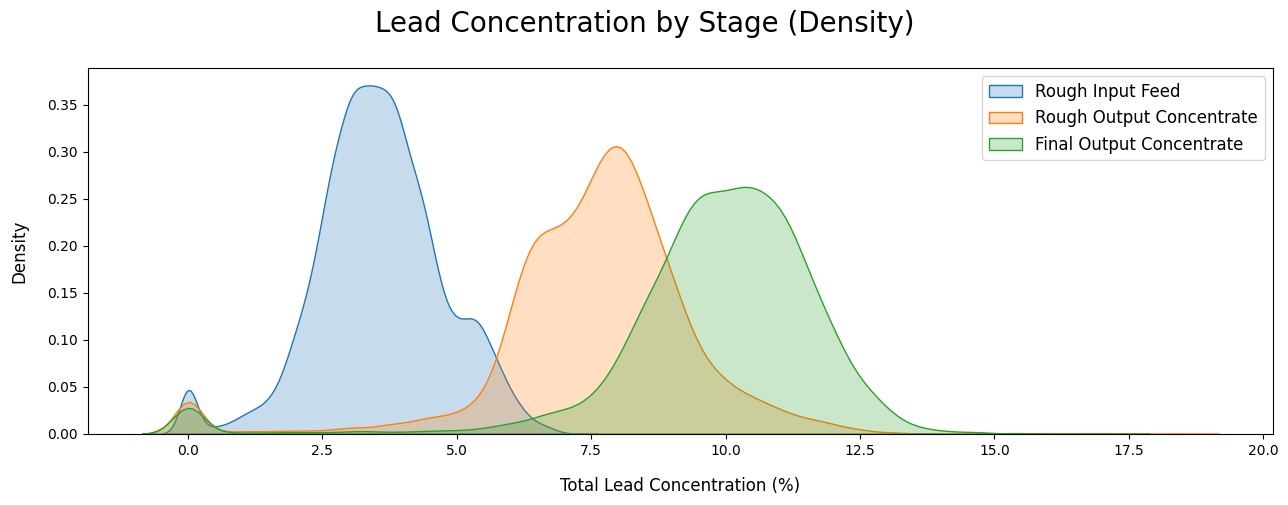

In [35]:
#visualize Lead 
fig=plt.figure(figsize=(13,5))
fig.suptitle('Lead Concentration by Stage (Density)',fontsize=20,y=1)

sns.kdeplot(metal_sum (gfull,'rougher.input.feed', '_pb'),label='Rough Input Feed',fill=True)
sns.kdeplot(metal_sum (gfull,'rougher.output.concentrate', '_pb'),label='Rough Output Concentrate', fill=True)
sns.kdeplot(metal_sum (gfull,'final.output.concentrate', '_pb'), label='Final Output Concentrate', fill=True)

plt.legend(fontsize=12)
plt.xlabel('Total Lead Concentration (%)', fontsize=12, labelpad=14)
plt.ylabel('Density', fontsize=12,labelpad=14)
# Add labels and title
plt.tight_layout()
plt.show()

Outliers are values that were in the negative or less than zero. 

Taking into consideration the total concentrations of all substances at different stages (raw feed, rougher concentrate, and final concentrate) there are values less than or equal to zero.  Since these are physical quantities being measured in gold purification having a negative value at one of the stages is an abnormality.  The full training set includes parts of the test set.  However it is not best practice to alter the test set.  This is the reason only adjusting the anomalies in the full training set.  The shape shows a difference after the edit. 


In [36]:
#calculate sMAPE
import numpy as np

def calculate_smape(actual, forecast):
    # Ensure inputs are numpy arrays
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Avoid division by zero and calculate sMAPE
    denominator = (np.abs(actual) + np.abs(forecast)) / 2
    nonzero_indices = denominator != 0  # Avoid division by zero
    numerator = np.abs(forecast - actual)
    
    smape = np.mean(numerator[nonzero_indices] / denominator[nonzero_indices]) * 100
    return smape

In [37]:
#calculate final sMAPE
def final_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

In [38]:
#Test best model on set subset  
#define for training models
fullX = gfull.drop(columns=['rougher.output.recovery', 'final.output.recovery', 'date'])
fully = gfull[['rougher.output.recovery', 'final.output.recovery']]

In [39]:
print(fullX.isnull().sum())  # Check for NaN values in X
print(fully.isnull().sum())  # Check for NaN values in y

print(np.isinf(fullX).sum())  # Check for infinity in X
print(np.isinf(fully).sum())  # Check for infinity in y

final.output.concentrate_ag                    82
final.output.concentrate_pb                    80
final.output.concentrate_sol                  373
final.output.concentrate_au                    79
final.output.tail_ag                           75
                                             ... 
secondary_cleaner.state.floatbank6_a_air       91
secondary_cleaner.state.floatbank6_a_level     90
rougher.input.total_concentration             227
rougher.output.total_concentration             90
final.output.total_concentration               82
Length: 87, dtype: int64
rougher.output.recovery    1417
final.output.recovery       283
dtype: int64
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.tail_ag                          0
                                             ..
secondary_cleaner.state.floatbank6_a_air      0
secondary_cl

In [40]:
fullX = fullX.fillna(fullX.median())  # Replace NaNs with median
fully = fully.fillna(fully.median())  # Replace NaNs with median

In [41]:
#define for training models
X = gtrain.drop(columns=['rougher.output.recovery', 'final.output.recovery', 'date'])
y = gtrain[['rougher.output.recovery', 'final.output.recovery']]

In [42]:
#define for test model 
gX = gtest.drop(columns=['rougher.output.recovery', 'final.output.recovery','date'])
gy = gtest[['rougher.output.recovery', 'final.output.recovery']]

In [43]:
X = X.fillna(X.median())  # Replace NaNs with median
y = y.fillna(y.median())  # Replace NaNs with median

In [44]:
print(X.isnull().sum())  # Check for NaN values in X
print(y.isnull().sum())  # Check for NaN values in y

print(np.isinf(X).sum())  # Check for infinity in X
print(np.isinf(y).sum())  # Check for infinity in y


primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

In [45]:
print(gX.isnull().sum())  # Check for NaN values in X
print(gy.isnull().sum())  # Check for NaN values in y

print(np.isinf(gX).sum())  # Check for infinity in X
print(np.isinf(gy).sum())  # Check for infinity in y

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

#Select best model

In [46]:
from sklearn.model_selection import cross_val_predict

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X, y)
y_pred_lr = cross_val_predict(lr_model, X, y, cv=5)
smape_lr = calculate_smape(y, y_pred_lr)
print(f"Full Training df Set Linear Regression sMAPE: {smape_lr:.2f}%")

Full Training df Set Linear Regression sMAPE: 12.16%


#remove use of full data to be able to test the model later

In [47]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X, y)
y_pred_rf = cross_val_predict(rf_model, X, y, cv=5)
smape_rf = calculate_smape(y, y_pred_rf)
print(f"Training Set Random Forest sMAPE: {smape_rf:.2f}%")

Training Set Random Forest sMAPE: 11.49%


The random forest seems to be the better model based on the lower sMAPE value. A lower percentage indicates that the model's predictions are closer to the actual values, meaning it is performing well.This will be used to evaluate the test model 

Optimize parameters and run best model (Random Forest) on training set. 

In [48]:
#find best parameters for Random Forest 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
rf_grid_search.fit(X, y)

best_rf_model = rf_grid_search.best_estimator_
print("Best Random Forest Parameters for Traing df:", rf_grid_search.best_params_)

Best Random Forest Parameters for Traing df: {'max_depth': 10, 'n_estimators': 100}


In [49]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X, y)
y_pred_rf = cross_val_predict(rf_model, X, y, cv=5)
smape_rf_rough = calculate_smape(y, y_pred_rf)
print(f"Test Dataframe Random Forest sMAPE for rougher.output.recovery: {smape_rf_rough:.2f}%")

Test Dataframe Random Forest sMAPE for rougher.output.recovery: 10.67%


In [50]:
#use optimized parameters to run on test set

In [51]:
from sklearn.model_selection import cross_val_predict

# Random Forest Regressor
y_pred_rf = cross_val_predict(rf_model, gX, gy, cv=5)
smape_rf_final = calculate_smape(gy, y_pred_rf)
print(f"Test Dataframe Random Forest sMAPE for final.output.recovery: {smape_rf_final:.2f}%")

Test Dataframe Random Forest sMAPE for final.output.recovery: 15.25%


In [52]:
#calculate final sMAPE
complete_smape = final_smape(smape_rf_rough, smape_rf_final)
print(f"Final sMAPE of Test Dataframe using Random Forest: {complete_smape:.2f}%")


Final sMAPE of Test Dataframe using Random Forest: 14.10%


#### Conclusion of Recovery of Gold in Mining 

After importing three raw data files from a gold mining company work began to build a model to predict rougher concentrate (recovery rougher.output.recovery) and final concentrate recovery (final.output.recovery). Recovery was verified to be calculated correctly.  In the training set the MAE between calculations and the feature values was so miniscule (9.3e-15). Some features were noted to not be available in the test set (35 columns).  These column values were merge in from the full raw data file.  

Some trends were noticed regarding elements throughout the gold purification process.  Golds highest concentration was at the end of the process; indicating a successful purification process.  Silver's highest concentration during the purification process is the product output from the second cleaning (primary_cleaner.output.tail_ag).  The presence of both lead and silver through the purification process was minority volumes. The average feed size is exactly the same according to the phase of gold purification between the two dataframes.  This is an indication that the machine learning model will be well trained since similiar data is present in both dataframes. 

Discovery was made that the best model to use was a Random Forest Regressor.  In testing the training model this achieved the low sMAPE value of 10.67%. The variables were then redefined to match the test set dataframe.  The optimization random forest regressor for 'roughter.output.recovery' and 'final.output.recovery' resulted in a sMAPE value of 15.24%. Both of these values were used to calculate the final sMAPE value of 0.141%. This model proficiently predicts gold recovery, helping to optimize production and eliminate unprofitable parameters. This effort paves the way for improved operational efficiency.